<a href="https://colab.research.google.com/github/gabryellesoares/BERT-project/blob/main/BERT_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementação de uma análise de sentimentos em reviews de compras feitas na Olist Store. A análise foi realizada utilizando o BERT, um modelo de pré-treinamento de processamento de linguagem natural.

## Importando as bibliotecas que serão necessárias para o desenvolvimento

In [ ]:
!pip install -qq transformers

In [108]:
import re
import nltk
import spacy
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import torch.nn.functional as F

from textwrap import wrap
from torch import nn, optim
from wordcloud import WordCloud
from nltk.corpus import stopwords
from transformers import AutoModel
from collections import defaultdict
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForPreTraining
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertModel, AdamW, get_linear_schedule_with_warmup

nltk.download('punkt')
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')

nlp = spacy.load('pt_core_news_sm')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Os datasets foram retirados <a href="https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce">deste</a> link. Podem ser encontrados dados referente aos pedidos, aos clientes, às reviews, aos vendedores, aos dados de geolocalização dos clientes e vendedores, entre outros.

## Configuração dos datasets

Neste projeto, utilizaremos apenas os dados com informações dos clientes, geolocalização, reviews e pedidos.

In [125]:
path = '/content/drive/MyDrive/Colab Notebooks/NLP_project/e-commerce_datasets/'
customers = pd.read_csv(path + 'olist_customers_dataset.csv')
geolocation = pd.read_csv(path + 'olist_geolocation_dataset.csv')
order_reviews = pd.read_csv(path + 'olist_order_reviews_dataset.csv')
orders = pd.read_csv(path + 'olist_orders_dataset.csv')

## Limpeza dos dados

Removendo colunas que não serão úteis para a análise

In [126]:
order_reviews = order_reviews.drop(columns=['review_creation_date', 'review_answer_timestamp'])
order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...


In [127]:
orders = orders.drop(columns=['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39


Fazendo a junção dos datasets 'orders' e 'order_reviews'

In [128]:
order_rev = pd.merge(orders, order_reviews)
order_rev['order_purchase_timestamp'] = pd.to_datetime(order_rev['order_purchase_timestamp'])
order_rev.head()

,order_id,customer_id,order_status,order_purchase_timestamp,review_id,review_score,review_comment_title,review_comment_message
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre..."
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,Muito bom o produto.
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,e73b67b67587f7644d5bd1a52deb1b01,5,NaN,NaN
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,359d03e676b3c069f62cadba8dd3f6e8,5,NaN,O produto foi exatamente o que eu esperava e e...
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,e50934924e227544ba8246aeb3770dd4,5,NaN,NaN


Criando duas novas colunas referenciando ao ano e ao mês de cada pedido

In [129]:
order_rev['year'] = order_rev['order_purchase_timestamp'].map(lambda x: x.year)
order_rev['month'] = order_rev['order_purchase_timestamp'].map(lambda x: x.month)

## Análise Exploratória

In [130]:
n_pedidos = order_rev.groupby(['year', 'month']).count()['order_id'].reset_index()
n_pedidos = n_pedidos.rename(columns={'year': 'Ano', 'month': 'Mês', 'order_id': 'Número de Pedidos'})
n_pedidos.head()

,Ano,Mês,Número de Pedidos
0,2016,9,4
1,2016,10,321
2,2016,12,1
3,2017,1,797
4,2017,2,1776


O gráfico mostrado abaixo é interativo. É possível visualizar um ou mais anos por vez clicando nos anos presentes no menu à direita da visualização, dar zoom selecionando determinada área do gráfico, e, ao passar o mouse em cima das marcações, temos informações como ano, mês, e o número de pedidos agrupadas em uma caixa. Os meses estão definidos como números de 1 a 12 (de janeiro a dezembro).

In [131]:
fig = px.line(n_pedidos, x="Mês", y="Número de Pedidos", color="Ano", text="Número de Pedidos", title="Número de vendas por mês <br><sup>de set/2009 até out/2017</sup>")
fig.update_traces(textposition="bottom right")
fig.update_layout(xaxis = dict(tickmode = 'array', tickvals = [i for i in range(1, 13)]))

fig.show()

No ano de 2016, começamos a ter informações apenas a partir de setembro, enquanto no ano de 2018 só temos dados registrados até outubro.

Como podemos ver na célula abaixo, os dados faltantes estão concentrados exatamente nas colunas em que serão analisadas na próxima fase. Por isso, iremos excluir os registros com dados faltantes e analisar apenas o que sobrar disso.

In [132]:
order_rev.isna().sum()

order_id                        0
customer_id                     0
order_status                    0
order_purchase_timestamp        0
review_id                       0
review_score                    0
review_comment_title        87656
review_comment_message      58247
year                            0
month                           0
dtype: int64

In [133]:
order_rev = order_rev.dropna()
order_rev.head()

,order_id,customer_id,order_status,order_purchase_timestamp,review_id,review_score,review_comment_title,review_comment_message,year,month
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,Muito bom o produto.,2018,7
15,dcb36b511fcac050b97cd5c05de84dc3,3b6828a50ffe546942b7a473d70ac0fc,delivered,2018-06-07 19:03:12,5a8608437f4b52bec5cd143f37258b5e,5,Nota dez,Obrigado pela atenção. Lojas lannister perfeit...,2018,6
23,f3e7c359154d965827355f39d6b1fdac,62b423aab58096ca514ba6aa06be2f98,delivered,2018-08-09 11:44:40,9a55cbc65c8fad47581da5ebbb2b373e,5,Ótimo,Sempre vou comprar aqui pois é a melhor parabéns,2018,8
25,acce194856392f074dbf9dada14d8d82,7e20bf5ca92da68200643bda76c504c6,delivered,2018-06-04 00:00:13,2d4303fd561eb4ab51c87faa6598dc10,1,NÃO RECOMENDO!!!!,Até o momento não recebi o produto Protetor De...,2018,6
30,1790eea0b567cf50911c057cf20f90f9,52142aa69d8d0e1247ab0cada0f76023,delivered,2018-04-16 21:15:39,764c587207b9589949abd863bdb72dec,1,Enganadores,Foi entregue um produto divergente do que eu h...,2018,4


In [134]:
# definindo as labels para cada score

def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

order_rev['sentiment'] = order_rev['review_score'].apply(to_sentiment)

Nos dois gráficos abaixo, podemos ver que os dados estão desbalanceados, onde grande parte deles obteve score **5**, aumentando, assim, a quantidade de dados atribuídos ao sentimento **'positivo'**.

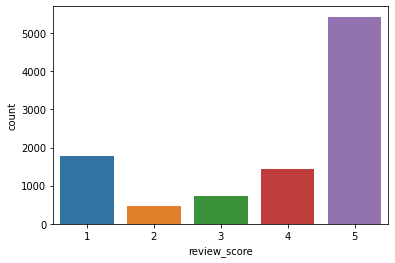

In [135]:
sns.countplot(data=order_rev, x='review_score')

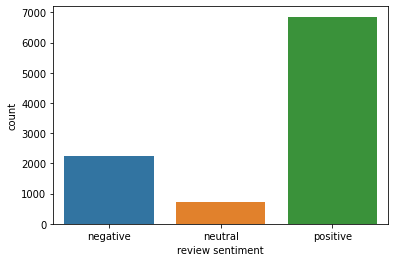

In [136]:
class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(data=order_rev, x='sentiment')
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

### Pré-processamento do texto

As próximas visualizações são de nuvens de palavras, ou seja, quanto maior o tamanho da palavra, mais frequente ela é nos registros do dataset. Para isso, conseguiremos ver as diferenças entre as visualizações quando os dados passaram ou não pelo pré-processamento.

In [139]:
order_rev['review_comment_message_cleaned'] = order_rev['review_comment_message'].apply(nltk.word_tokenize)

order_rev['review_comment_message_cleaned'] = order_rev['review_comment_message_cleaned'].apply(lambda x: [item for item in x if item not in stop_words])

regex = '[a-z]+'
order_rev['review_comment_message_cleaned'] = order_rev['review_comment_message_cleaned'].apply(lambda x: [item for item in x if re.match(regex, item)])

order_rev['review_comment_message_cleaned'] = order_rev['review_comment_message_cleaned'].apply(lambda x: [token.lemma_ for token in nlp(' '.join(x))])

order_rev['review_comment_message_cleaned'] = order_rev['review_comment_message_cleaned'].apply(lambda x: ' '.join(x))

### WordClouds

In [161]:
'''
Função auxiliar para plotar o gráfico de WordCloud
sentiment = negative, neutral or positive
stop_words = dicionário de stop_words
cleaned = utilizar os dados pré-processados ou não
color = cor de fundo da visualização
'''
def wordcloud_draw(sentiment, stop_words=[], cleaned=False, color='white'):
  x = {'negative': 0, 'neutral': 1, 'positive': 2}
  column = 'review_comment_message_cleaned' if cleaned else 'review_comment_message'
  words = order_rev[order_rev['sentiment'] == x[sentiment]][column].values
  wordcloud = WordCloud(stopwords=stop_words, background_color=color, width=2500, height=2500).generate(str(words))
  
  plt.figure(figsize = (15,10))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

WordCloud: sentimento negativo (score 1 ou 2)

WordCloud dos dados "sujos" (sem pré-processamento)


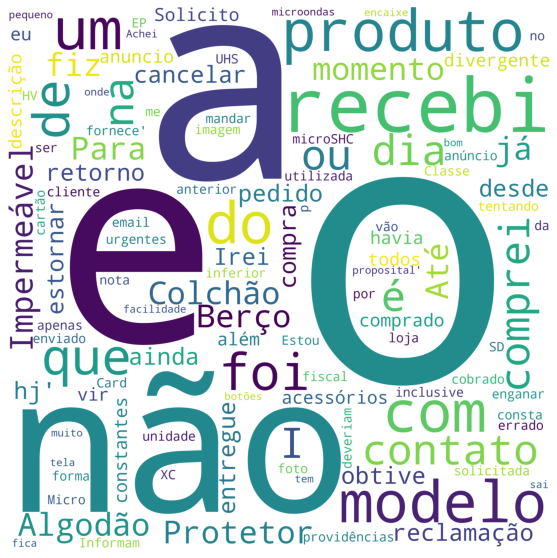


WordCloud dos dados "sujos" sem stop-words


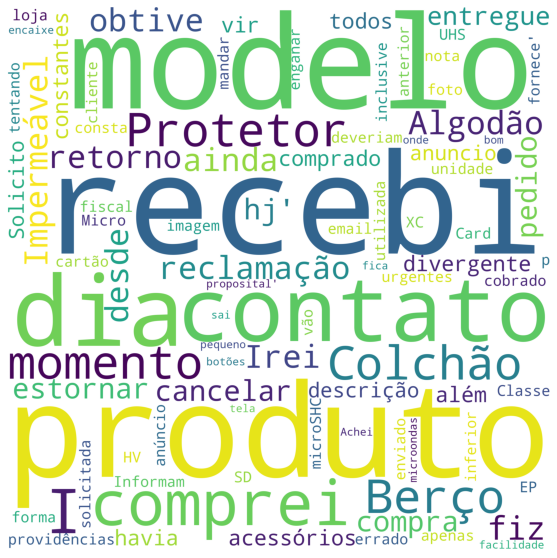


WordCloud dos dados com o pré-processamento completo


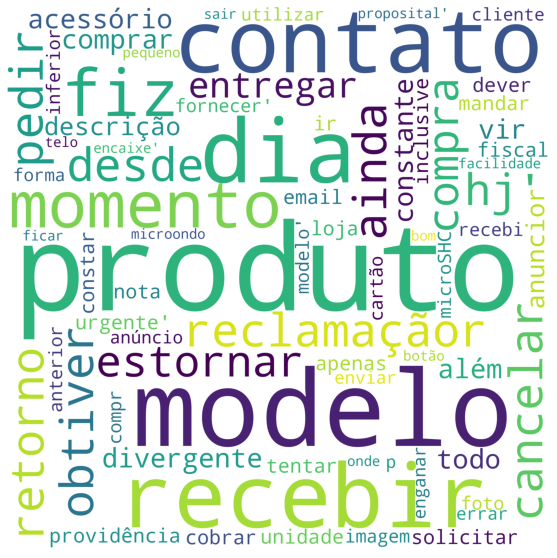

In [163]:
print('WordCloud: sentimento negativo (score 1 ou 2)')

print('\nWordCloud dos dados "sujos" (sem pré-processamento)')
wordcloud_draw(sentiment='negative')

print('\nWordCloud dos dados "sujos" sem stop-words')
wordcloud_draw(sentiment='negative', stop_words=stop_words)

print('\nWordCloud dos dados com o pré-processamento completo')
wordcloud_draw(sentiment='negative', stop_words=stop_words, cleaned=True)

WordCloud: sentimento neutro (score 3)

WordCloud dos dados "sujos" (sem pré-processamento)


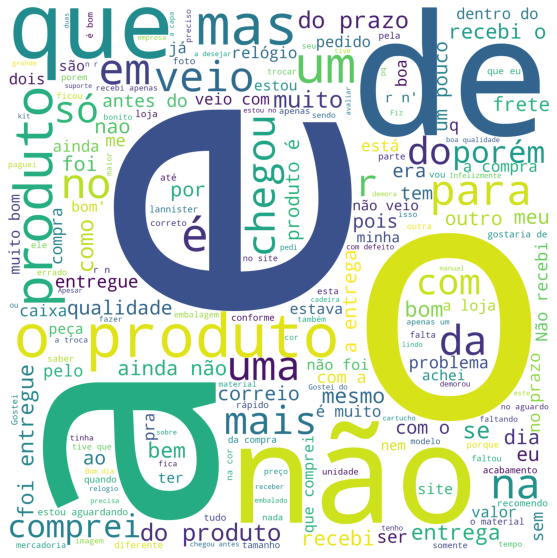


WordCloud dos dados "sujos" sem stop-words


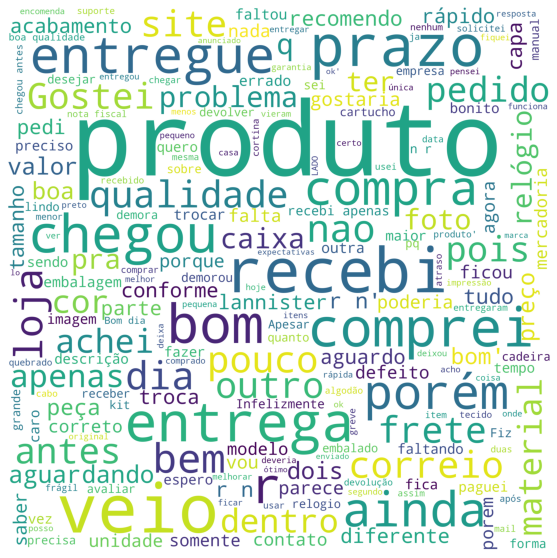


WordCloud dos dados com o pré-processamento completo


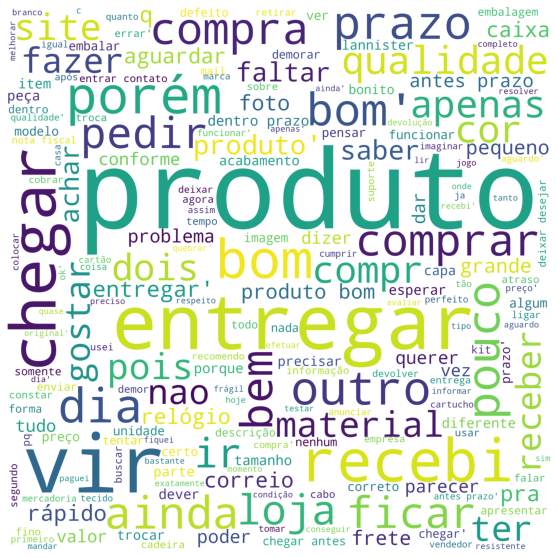

In [164]:
print('WordCloud: sentimento neutro (score 3)')

print('\nWordCloud dos dados "sujos" (sem pré-processamento)')
wordcloud_draw(sentiment='neutral')

print('\nWordCloud dos dados "sujos" sem stop-words')
wordcloud_draw(sentiment='neutral', stop_words=stop_words)

print('\nWordCloud dos dados com o pré-processamento completo')
wordcloud_draw(sentiment='neutral', stop_words=stop_words, cleaned=True)

WordCloud: sentimento positivo (score 4 ou 5)

WordCloud dos dados "sujos" (sem pré-processamento)


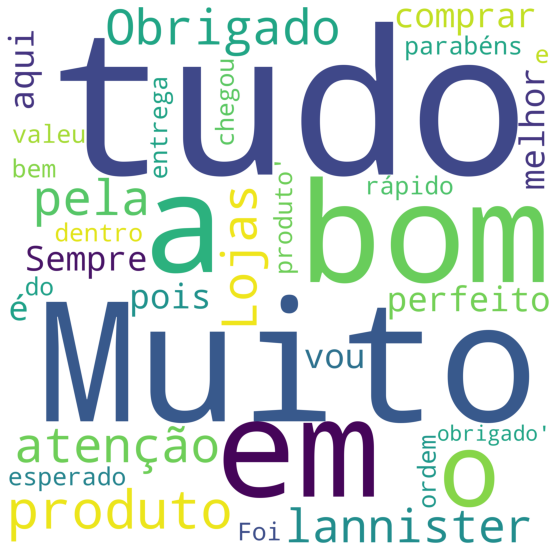


WordCloud dos dados "sujos" sem stop-words


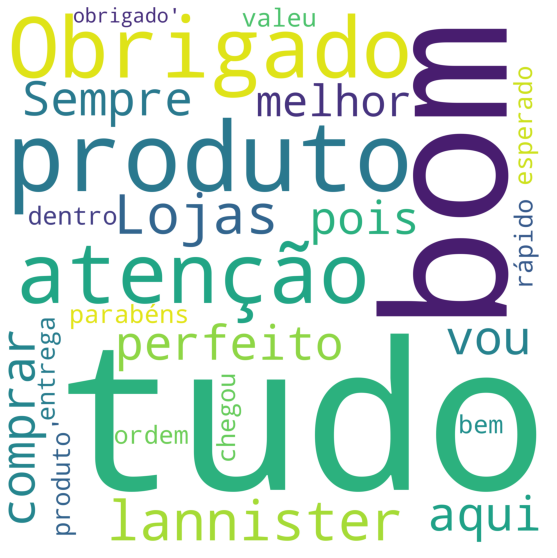


WordCloud dos dados com o pré-processamento completo


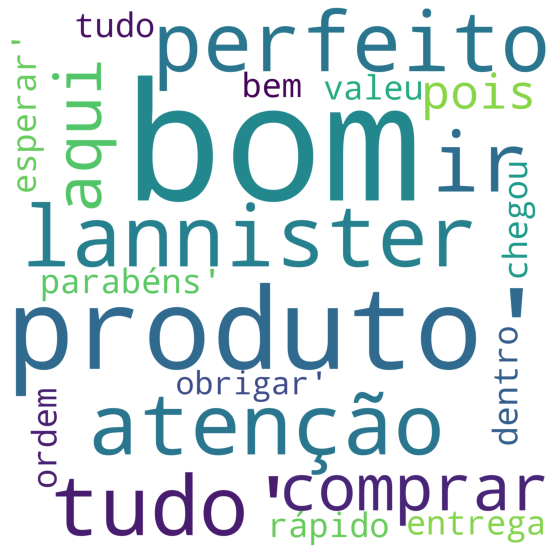

In [165]:
print('WordCloud: sentimento positivo (score 4 ou 5)')

print('\nWordCloud dos dados "sujos" (sem pré-processamento)')
wordcloud_draw(sentiment='positive')

print('\nWordCloud dos dados "sujos" sem stop-words')
wordcloud_draw(sentiment='positive', stop_words=stop_words)

print('\nWordCloud dos dados com o pré-processamento completo')
wordcloud_draw(sentiment='positive', stop_words=stop_words, cleaned=True)

## Pré-processamento dos dados


O BERT utiliza sequências de tamanho fixo. Para escolher o tamanho máximo, podemos verificar o tamanho do token de cada review e plotar um gráfico para uma melhor visualização.

In [22]:
token_lens = [len(tokenizer.encode(review)) if pd.notna(review) else 0 for review in order_rev['review_comment_message']]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



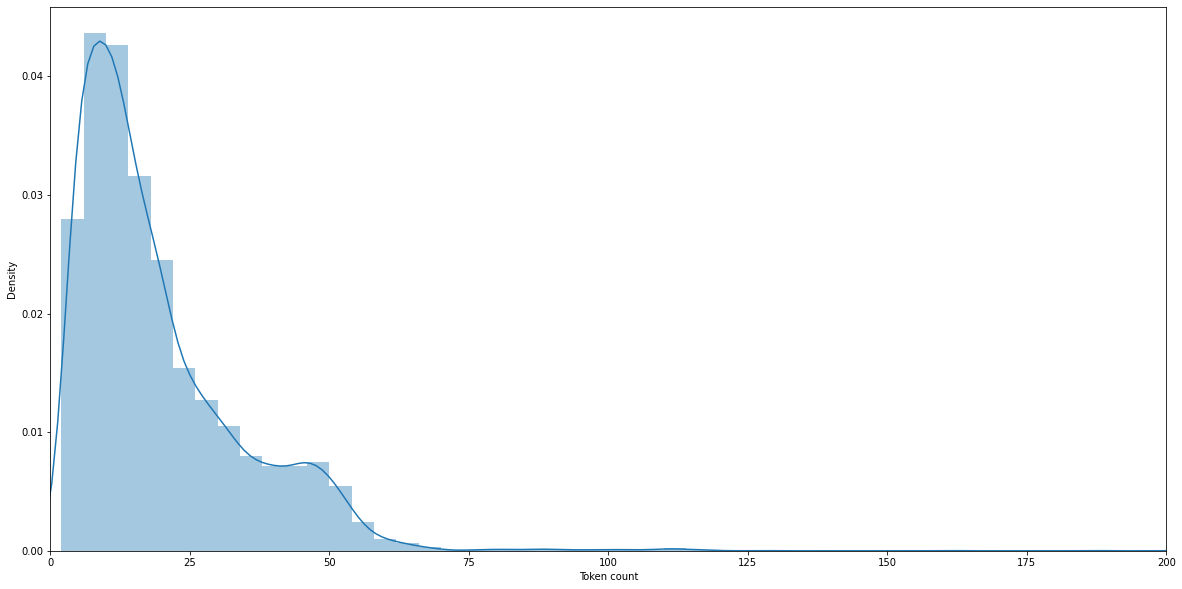

In [23]:
plt.figure(figsize=(20, 10))
sns.distplot(token_lens)
plt.xlim([0, 200]);
plt.xlabel('Token count');

In [25]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [26]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df['review_comment_message'].to_numpy(),
    targets=df['sentiment'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [15]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Dividindo os dados entre conjuntos de treino e de teste

In [16]:
df_train, df_test = train_test_split(order_rev, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [17]:
df_train.shape, df_val.shape, df_test.shape

((8855, 11), (492, 11), (492, 11))

No gráfico acima, vê-se que o tamanho máximo dos tokens está entre 100 e 125. Utilizaremos o MAX_LEN de 160, pois ainda há alguns (poucos) tokens de tamanho maior que 125. Em seguida, podemos dividir os dados entre 

In [27]:
MAX_LEN = 160
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



## Definindo o classificador de sentimentos BERT

In [20]:
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'
model = AutoModelForPreTraining.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=False)

Some weights of BertForPreTraining were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [33]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Treinamento do modelo

Utilizando um otimizador para reproduzir o procedimento

In [35]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



In [36]:
# função para treinar o modelo por uma época

def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [37]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

#### Executando o modelo

In [38]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_fi

Train loss 0.40579734664638983 accuracy 0.8587238848108414


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest s

Val   loss 0.37461806647479534 accuracy 0.8719512195121952

Epoch 2/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest s

Train loss 0.29068308934192794 accuracy 0.8993788819875776


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.3883790532127023 accuracy 0.8516260162601627

Epoch 3/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest s

Train loss 0.21589086321098494 accuracy 0.9308865047995483


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest s

Val   loss 0.45752084348350763 accuracy 0.8597560975609757

Epoch 4/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.16084816893192835 accuracy 0.951665725578769


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True`

Val   loss 0.5310015240684152 accuracy 0.8516260162601627

Epoch 5/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest s

Train loss 0.13147208001128388 accuracy 0.9637492941840768


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.553393361158669 accuracy 0.8556910569105692

CPU times: user 18min 4s, sys: 8.54 s, total: 18min 12s
Wall time: 18min 23s


Visualizando a aprendizagem do modelo através do treino e da validação durante 5 épocas

In [63]:
t = [x.item() for x in history['train_acc']]
v = [x.item() for x in history['val_acc']]

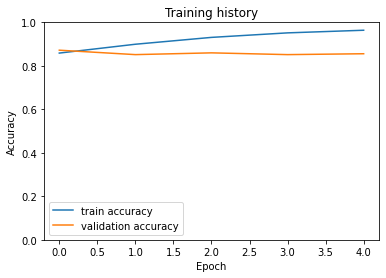

In [66]:
plt.plot(t, label='train accuracy')
plt.plot(v, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Avaliando a acurácia do modelo

Acurácia de aproximadamente 87% no conjunto de testes.

In [71]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_fi

0.8699186991869919

In [67]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [75]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version,

Nas métricas do relatório de classificação, podemos verificar que é difícil classificar uma review como *'neutra'*, podendo (ou não) ser devido à baixa quantidade de reviews com esse score. Também conseguimos verificar que, apesar da classe de sentimentos positivos ser ligeiramente maior do que as outras duas, as classes de sentimentos negativo e positivo são divergentes, tornando mais fácil de classificar entre um e outro.

In [76]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.81      0.86      0.83       106
     neutral       0.23      0.15      0.18        40
    positive       0.94      0.96      0.95       346

    accuracy                           0.87       492
   macro avg       0.66      0.66      0.65       492
weighted avg       0.85      0.87      0.86       492



In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

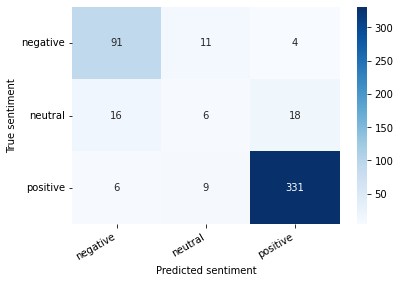

In [78]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Visualizando um exemplo de review que está no dataset. Nas células abaixo temos as informações do sentimento correto (de acordo com o score dado pelo usuário), e abaixo temos um gráfico de barras representando a probabilidade de cada sentimento para essa mesma review, sendo estas probabilidades avaliadas pelo modelo.

In [84]:
idx = 5

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [85]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Estou preocupado, pois até agora não recebi o produto, e nem fui
comunicado o porque está atrasado.

True sentiment: negative


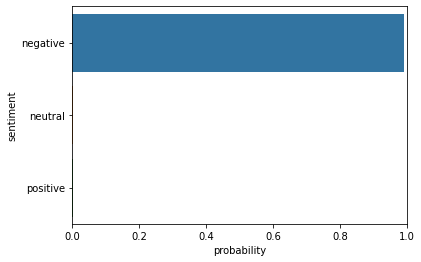

In [86]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

## Teste livre

Abaixo é possível inserir algum texto alterando a variável *'review_text'* e verificar o sentimento resultante de acordo com o modelo treinado.

In [93]:
review_text = "meu pedido chegou quebrado"

In [94]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [95]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: meu pedido chegou quebrado
Sentiment  : negative
